In [21]:
!pip install vncorenlp

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
import os
import urllib.request

# Thư mục chứa VnCoreNLP
MODEL_DIR = "vncorenlp"
os.makedirs(MODEL_DIR, exist_ok=True)

# Các file cần tải
FILES = {
    "VnCoreNLP-1.1.1.jar": "https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar",
    "vi-vocab": "https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab",
    "wordsegmenter.rdr": "https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr"
}

# Tạo thư mục models/wordsegmenter nếu cần
os.makedirs(os.path.join(MODEL_DIR, "models/wordsegmenter"), exist_ok=True)

# Tải từng file nếu chưa có
for name, url in FILES.items():
    out_path = os.path.join(MODEL_DIR, name if name.endswith(".jar") else f"models/wordsegmenter/{name}")
    if not os.path.exists(out_path):
        print(f"Downloading {name}...")
        urllib.request.urlretrieve(url, out_path)
    else:
        print(f"{name} already exists")

print("Download complete!")


Download complete!


In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tqdm import tqdm
import warnings
import time
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Dataset

In [2]:
from vncorenlp import VnCoreNLP

rdrsegmenter = VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g')
def preprocess_text(text, segmenter):
    tokens = segmenter.tokenize(text)
    return " ".join([tok for tok in tokens[0]])

data = pd.read_csv("Dataset/vsa_food_rv_train_clean.csv", encoding="utf-8")
data["Comment"] = [preprocess_text(t, rdrsegmenter) for t in data["Comment"]]

X = data["Comment"]
y = data["Rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=2020, test_size=0.2, stratify=y
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 10326, Test size: 2582


# PhoBERT Dataset Definition

In [3]:
class PhoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# PhoBERT-based Classification Model

In [4]:
class PhoBERTClassifier(torch.nn.Module):
    def __init__(self, n_classes=2, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base-v2")
        self.drop = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        last_hidden_state = outputs.last_hidden_state  
        mask = attention_mask.unsqueeze(-1).float()    
        masked_hidden = last_hidden_state * mask        
        sentence_embedding = masked_hidden.sum(dim=1) / mask.sum(dim=1)

        x = self.drop(sentence_embedding)
        logits = self.fc(x)

        return logits


In [5]:
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [6]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return (correct_predictions.double() / len(data_loader.dataset), 
            np.mean(losses), predictions, true_labels)

# Tokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

train_dataset = PhoBERTDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = PhoBERTDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
tokenizer.tokenize("thực_đơn hấp_dẫn")

['thực_đơn', 'hấp_dẫn']

In [9]:
model = PhoBERTClassifier(n_classes=2, dropout=0.3)
model = model.to(device)

class_counts = y_train.value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.FloatTensor(class_weights.values).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

In [10]:
import os

history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_accuracy = 0
start_time = time.time()

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 50)
    
    train_acc, train_loss = train_epoch(
        model, train_loader, loss_fn, optimizer, scheduler, device
    )
    
    print(f'Train loss: {train_loss:.4f} - Train accuracy: {train_acc:.4f}')
    
    val_acc, val_loss, _, _ = eval_model(model, test_loader, loss_fn, device)
    
    print(f'Val loss: {val_loss:.4f} - Val accuracy: {val_acc:.4f}')
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        os.makedirs("Model", exist_ok=True)
        torch.save(model.state_dict(), 'Model/phobert_best.pth')
        best_accuracy = val_acc
        print(f'Model saved with accuracy: {best_accuracy:.4f}')

end_time = time.time()
print(f"\n*** Training hoàn tất sau {(end_time - start_time):.2f}s ***")


Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 646/646 [14:15<00:00,  1.32s/it]


Train loss: 0.3242 - Train accuracy: 0.9085


Evaluating: 100%|██████████| 162/162 [00:37<00:00,  4.26it/s]


Val loss: 0.3831 - Val accuracy: 0.9241
Model saved with accuracy: 0.9241

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 646/646 [14:20<00:00,  1.33s/it]


Train loss: 0.2444 - Train accuracy: 0.9426


Evaluating: 100%|██████████| 162/162 [00:37<00:00,  4.28it/s]


Val loss: 0.3278 - Val accuracy: 0.9268
Model saved with accuracy: 0.9268

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 646/646 [14:13<00:00,  1.32s/it]


Train loss: 0.1967 - Train accuracy: 0.9591


Evaluating: 100%|██████████| 162/162 [00:37<00:00,  4.32it/s]

Val loss: 0.3709 - Val accuracy: 0.9237

*** Training hoàn tất sau 2684.43s ***


# Evaluation

In [11]:
model.load_state_dict(torch.load('Model/phobert_best.pth'))
_, _, predictions, true_labels = eval_model(model, test_loader, loss_fn, device)

Evaluating: 100%|██████████| 162/162 [00:37<00:00,  4.29it/s]


In [12]:
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.89      0.82      0.85       657
    Positive       0.94      0.96      0.95      1925

    accuracy                           0.93      2582
   macro avg       0.91      0.89      0.90      2582
weighted avg       0.93      0.93      0.93      2582



In [13]:
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='macro')
print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1:.4f}")


Accuracy: 0.9268
F1-Score (macro): 0.9010


# Confusion Matrix

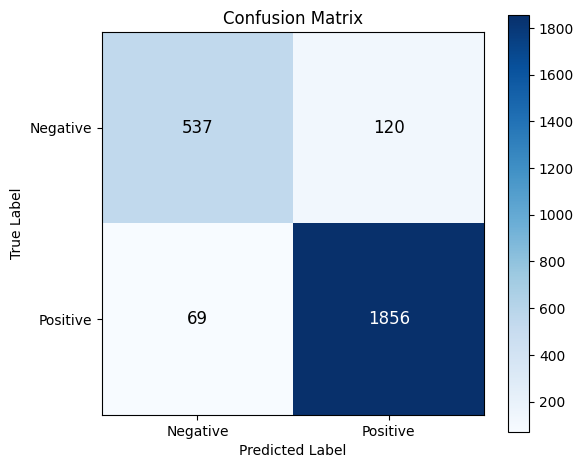

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black",
                fontsize=12
            )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, ['Negative', 'Positive'])

# Misclassified samples

In [15]:
error_df = pd.DataFrame({
    "text": X_test,
    "true_label": true_labels,
    "pred_label": predictions
})

label_map = {0: "Negative", 1: "Positive"}
error_df["true_label_name"] = error_df["true_label"].map(label_map)
error_df["pred_label_name"] = error_df["pred_label"].map(label_map)

misclassified = error_df[error_df["true_label"] != error_df["pred_label"]]

print(f"\nTổng số câu dự đoán sai: {len(misclassified)} / {len(X_test)}")



Tổng số câu dự đoán sai: 189 / 2582


In [16]:
false_positive = misclassified[
    (misclassified["true_label"] == 0) &
    (misclassified["pred_label"] == 1)
]

print(f"\nNegative → Positive (False Positive): {len(false_positive)} câu\n")

for i, row in false_positive.head(20).iterrows():  
    print("Text:", row["text"])
    print("True:", row["true_label_name"], 
          "| Pred:", row["pred_label_name"])
    print("-" * 120)



Negative → Positive (False Positive): 120 câu

Text: emj _ sparkles địa_điểm mọi người chú_ý là ngõ hàng cháo chứ không phải phố hàng cháo bên cạnh nha ngay gần nhà số 6 mà cô bán ngay vỉa_hè luôn ý ) ) vào là nhìn thấy luôn nhé emj _ sparkles không_gian ngồi ngắm khí giời ăn hoặc mang về emj _ sparkles đồ_ăn hot lâu rồi nhưng chưa ăn thử cái món này bao_giờ ) ) đặc_biệt là mình lại không chọn lặn_lội lên phố cổ để ăn thử mình chọn quán nhỏ nhỏ ở nơi chẳng mấy_ai biết thế_này thôi đầu_tiên chọc thử cái vỏ nếp nướng lúc ở trên vỉ quay sang bảo bạn “ ơ mày ơi cứng thế_này sao nhai ?
True: Negative | Pred: Positive
------------------------------------------------------------------------------------------------------------------------
Text: mình đến đây 2 lần sau lời giới_thiệu của đứa em quán này mình đi tối phải nói là rất đông nhé nhân_viên ở đây cũng đông lắm hầu_hết là sinh_viên làm thêm nhưng các em khá nhanh_nhẹn nhiệt_tình và cũng chăm_sóc các bàn tốt chấm điểm tốt nhé bọn mình ha

In [17]:
false_negative = misclassified[
    (misclassified["true_label"] == 1) &
    (misclassified["pred_label"] == 0)
]

print(f"\nPositive → Negative (False Negative): {len(false_negative)} câu\n")

for i, row in false_negative.head(20).iterrows(): 
    print("Text:", row["text"])
    print("True:", row["true_label_name"], 
          "| Pred:", row["pred_label_name"])
    print("-" * 120)


Positive → Negative (False Negative): 69 câu

Text: hôm_nay đẹp trời tự_nhiên lại muốn ăn lẩu haidilao vừa gọi hotline nhà_hàng bảo là đã đóng_cửa từ lúc 00 00 13/7 emj _ loudly _ crying _ face emj _ loudly _ crying _ face emj _ loudly _ crying _ face emj _ weary _ face chỉ ship mang về lúc đầu cũng hơi hoang_mang vì chưa bao_giờ đặt mang về nhưng vì ghiền sảng quá nên mắt_nhắm_mắt_mở đặt thử xem sao thì lại ối dồi ôi !
True: Positive | Pred: Negative
------------------------------------------------------------------------------------------------------------------------
Text: thứ 4 mình có đặt 2 pizza bên pizza express khuyến_mãi nên chỉ còn 200 2 chiếc seafood và thịt nguội nói_chung pizza không bị bứ nhưng vẫn còn nguyên bột trắng dưới đáy tôm mực khá ok chứ không bị mủn pizza còn lại thì mình thấy bình_thường chốt lại là để ăn vào những ngày thiếu tiền thì cũng được
True: Positive | Pred: Negative
-------------------------------------------------------------------------------------

# Train & Val loss

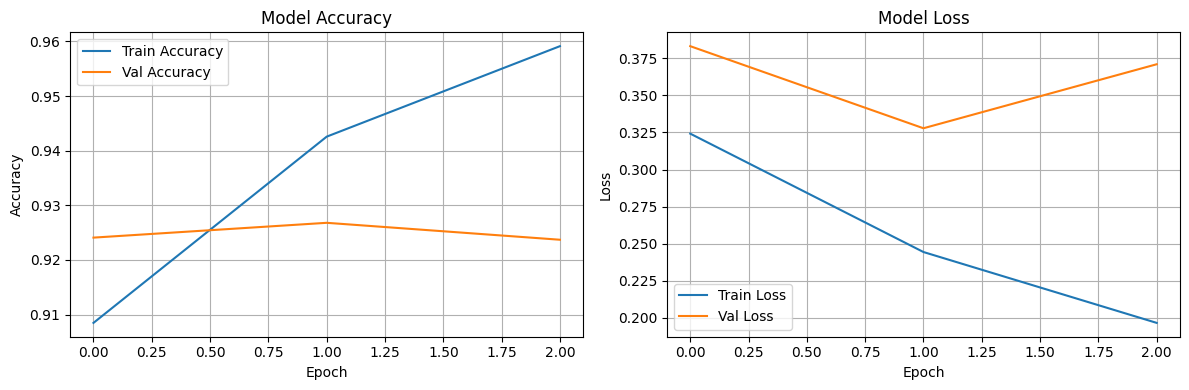

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Sample

In [19]:
def predict_sentiment(text, model, tokenizer, device, max_len=256):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, pred = torch.max(outputs, dim=1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    return pred.item(), probs[0].cpu().numpy()

In [20]:
test_texts = [
    "Món ăn rất ngon, tôi rất thích",
    "Đồ ăn dở tệ, không bao giờ quay lại nữa",
    "Bình thường, không có gì đặc biệt"
]

for text in test_texts:
    pred, probs = predict_sentiment(text, model, tokenizer, device)
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"\nText: {text}")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: Negative={probs[0]:.3f}, Positive={probs[1]:.3f}")


Text: Món ăn rất ngon, tôi rất thích
Prediction: Positive
Confidence: Negative=0.042, Positive=0.958

Text: Đồ ăn dở tệ, không bao giờ quay lại nữa
Prediction: Negative
Confidence: Negative=0.992, Positive=0.008

Text: Bình thường, không có gì đặc biệt
Prediction: Negative
Confidence: Negative=0.587, Positive=0.413
